# Classification with Noisy Labels

This notebook demonstrates binary classification with noisy labels on the simple data_banknote_authentication dataset.

The apporach is more general and can handle multi-class setup (not just binary).

### Common Imports

In [1]:
import sys
import os

root_path = os.path.dirname(os.getcwd())
src_path = os.path.join(root_path, "src")
sys.path.insert(0, src_path)

%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt

### Helper functions

In [2]:
def make_balanced(tmp_df, TARGET_LABEL):
    """ Make the dataset balanced by downsampling the majority class """
    df_majority = tmp_df[tmp_df[TARGET_LABEL] == 0]
    df_minority = tmp_df[tmp_df[TARGET_LABEL] == 1]

    # Downsample majority class
    df_majority_downsampled = resample(df_majority, 
                                       replace=False,              # sample without replacement
                                       n_samples=len(df_minority), # to match minority class
                                       random_state=None)        # reproducible results
    # Combine minority class with downsampled majority class
    df_downsampled = pd.concat([df_majority_downsampled, df_minority])
    df_downsampled = df_downsampled.sample(frac=1) #Shuffle the data
    df_downsampled = df_downsampled.reset_index() #Reset the index
    df_downsampled = df_downsampled.drop(columns=['index']) # Drop original index col
    return df_downsampled


def get_X_y(tmp_df, TARGET_LABEL):
    """ Extract X,y as torch.Tensor from dataframe """
    NON_LBL = [c for c in tmp_df.columns if c != TARGET_LABEL]
    X = tmp_df[NON_LBL].to_numpy()
    y = tmp_df['authentic'].to_numpy()
    return torch.from_numpy(X), torch.from_numpy(y)


def flip(y_tmp, p01, p10):
    """ Flip the labels with a certain probability """

    index_with_y_eq_1 = torch.arange(y_tmp.shape[0])[y_tmp == 1]
    index_with_y_eq_0 = torch.arange(y_tmp.shape[0])[y_tmp == 0]
    
    n_flips_10 = int(p10 * index_with_y_eq_1.shape[0])
    n_flips_01 = int(p01 * index_with_y_eq_0.shape[0])
    
    index_with_y_eq_1_permuted = index_with_y_eq_1[torch.randperm(index_with_y_eq_1.shape[0])]
    index_with_y_eq_0_permuted = index_with_y_eq_0[torch.randperm(index_with_y_eq_0.shape[0])]
       
    index_flips_10 = index_with_y_eq_1_permuted[:n_flips_10]   
    index_flips_01 = index_with_y_eq_0_permuted[:n_flips_01]   

    y_noisy = y_clean.clone()
    y_noisy[index_flips_10] = 0
    y_noisy[index_flips_01] = 1
    return y_noisy

def show_results(y_clean, y_noisy, y_pred, prob=None, title=None):
    """ 
    Make some nice plots of the results. 
    It expect the clean, noisy and predicted labels (of shape N).
    Optionally it can accept the predicted probabilities (of shape (N,2)) 
    """
    cm_pred_wrt_clean = sklearn.metrics.confusion_matrix(y_true=y_clean, y_pred=y_pred)
    cm_pred_wrt_noisy = sklearn.metrics.confusion_matrix(y_true=y_noisy, y_pred=y_pred)
    cm_flip = sklearn.metrics.confusion_matrix(y_true=y_clean, y_pred=y_noisy)
    
    accuracy_wrt_clean = sklearn.metrics.accuracy_score(y_true=y_clean, y_pred=y_pred)
    accuracy_wrt_noisy = sklearn.metrics.accuracy_score(y_true=y_noisy, y_pred=y_pred)
    noise_rate = 1.0 - sklearn.metrics.accuracy_score(y_true=y_noisy, y_pred=y_clean)
    
    n_classes = cm_flip.shape[0]
    if prob is not None:
        fig, axes = plt.subplots(ncols=4, figsize=(16,4))
        _show_hist_internal(axes[3], y_clean, prob)
    else:
        fig, axes = plt.subplots(ncols=3, figsize=(12,4))
    
    # image 
    im0 = axes[0].imshow(cm_pred_wrt_clean)
    im1 = axes[1].imshow(cm_pred_wrt_noisy)
    im2 = axes[2].imshow(cm_flip)
    
    # colorbar
    # _ = plt.colorbar(im0, ax=axes[0])
    # _ = plt.colorbar(im1, ax=axes[1])
    # _ = plt.colorbar(im2, ax=axes[2])
    
    # write numbers in the centers
    for i in range(n_classes):
        for j in range(n_classes):
            _ = axes[0].text(j, i, cm_pred_wrt_clean[i, j], ha="center", va="center", color='red')
            _ = axes[1].text(j, i, cm_pred_wrt_noisy[i, j], ha="center", va="center", color='red')    
            _ = axes[2].text(j, i, cm_flip[i, j], ha="center", va="center", color='red')
                
    # titles
    _ = axes[0].set_title("Acc = {0}".format(accuracy_wrt_clean))
    _ = axes[1].set_title("Acc = {0}".format(accuracy_wrt_noisy))
    _ = axes[2].set_title("Flip Matrix. Rate = {0}".format(noise_rate))
    
    # axis labels
    axes[0].set_xlabel("predicted labels")
    axes[0].set_ylabel("clean labels")
    
    axes[1].set_xlabel("predicted labels")
    axes[1].set_ylabel("noisy labels")
    
    axes[2].set_xlabel("noisy labels")
    axes[2].set_ylabel("clean labels")
    
    # ticks
    ix = [i for i in range(n_classes)]
    axes[0].set_xticks(ticks=ix)
    axes[0].set_yticks(ticks=ix)
    axes[1].set_xticks(ticks=ix)
    axes[1].set_yticks(ticks=ix)
    axes[2].set_xticks(ticks=ix)
    axes[2].set_yticks(ticks=ix)
    
    if title is not None:
        fig.suptitle(title)
    plt.close(fig)
    return fig


def _show_hist_internal(ax, y_clean, prob):
    mask0 = (y_clean == 0)
    plt.hist(prob[mask0,1], label='class0', alpha=.5, range=(0,1), bins=25, edgecolor='black')
    plt.hist(prob[~mask0,1], label='class1', alpha=.5, range=(0,1), bins=25, edgecolor='black')
    ax.set_xlabel("prob for class 1")
    ax.set_ylabel("pdf")
    plt.legend()


def _show_auc_internal(ax, y_clean, prob):

    fpr0, tpr0, thr0 = sklearn.metrics.roc_curve(1-y_clean, prob[:,0])
    auc0 = sklearn.metrics.roc_auc_score(1-y_clean, prob[:, 0])
    fpr1, tpr1, thr1 = sklearn.metrics.roc_curve(y_clean, prob[:,1])
    auc1 = sklearn.metrics.roc_auc_score(y_clean, prob[:, 1])


    ax.plot(fpr0, tpr0)
    ax.plot(fpr1, tpr1)
    ax.set_xlabel("fpr")
    ax.set_ylabel("tpr")
        
    # ax.set_title("AUC = {0}".format(auc_list))
    ax.set_title("AUC = {:.2f},  {:.2f}".format(auc0, auc1))
 
    
def show_AUC(y_clean, prob):
    fig, axes = plt.subplots(ncols=1, figsize=(4,4))
    _show_auc_internal(axes, y_clean, prob)
    plt.close(fig)
    return fig  

def show_hist(y_clean, prob):
    fig, axes = plt.subplots(ncols=1, figsize=(4,4))
    _show_hist_internal(axes, y_clean, prob)
    plt.close(fig)
    return fig  

In [3]:
import numpy as np
import pandas as pd
import sklearn.metrics
from sklearn.utils import shuffle
from sklearn.utils import resample
import torch

df_raw = pd.read_csv('data_banknote_authentication.txt', 
                     names=['variance', 'skewness', 'kurtosis', 'entropy', 'authentic'])

df_balanced = make_balanced(df_raw, 'authentic')
X,y_clean = get_X_y(df_balanced, 'authentic')
df_balanced['authentic'].value_counts()

df_balanced

,variance,skewness,kurtosis,entropy,authentic
0,-2.180200,3.379100,-1.2256,-2.662100,1
1,-0.106480,-0.767710,7.7575,0.641790,0
2,-5.121600,-5.311800,10.3846,-1.061200,1
3,-0.071503,3.741200,-4.5415,-4.252600,1
4,1.131500,7.921200,1.0930,-2.844400,0
...,...,...,...,...,...
1215,0.570600,-0.024841,1.2421,-0.562080,0
1216,3.466700,-4.072400,4.2882,1.541800,0
1217,-2.336100,11.960400,3.0835,-5.443500,0
1218,-4.855400,-5.903700,10.9818,-0.821990,1


# Flip the labels and show the confusion matrix

Note that we are using an asymmetric flipping. This is because we expect that the
case-in-controll and controll-in-case error to appear with very different probabilities. 

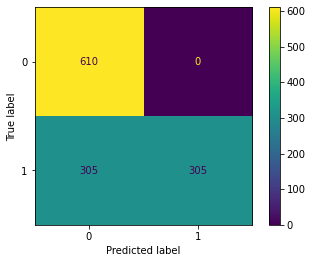

In [4]:
y_noisy = flip(y_clean, p01=0.0, p10=0.5)
cm = sklearn.metrics.confusion_matrix(y_true=y_clean, y_pred=y_noisy)
disp = sklearn.metrics.ConfusionMatrixDisplay(cm)
disp.plot()

# Compare different classifiers  classifiers

### Scikit Learn KNN with K=1

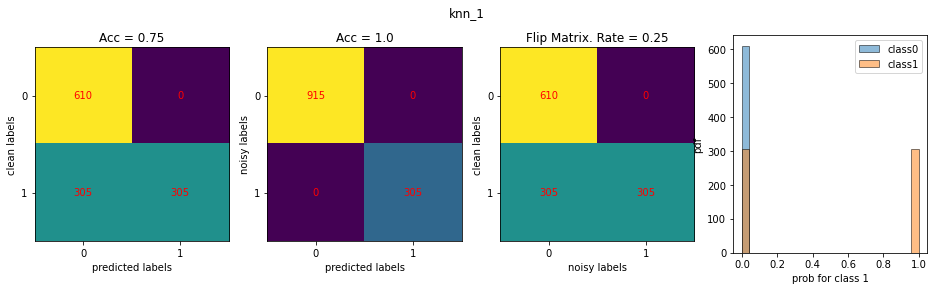

In [6]:
from sklearn.neighbors import KNeighborsClassifier

clf1 = KNeighborsClassifier(n_neighbors=1)
clf1.fit(X,y_noisy)
y_pred = clf1.predict(X)
prob = clf1.predict_proba(X)
fig_knn1 = show_results(y_clean, y_noisy, y_pred, prob, title="knn_1")
fig_knn1

### Scikit Learn KNN classifier with K=20

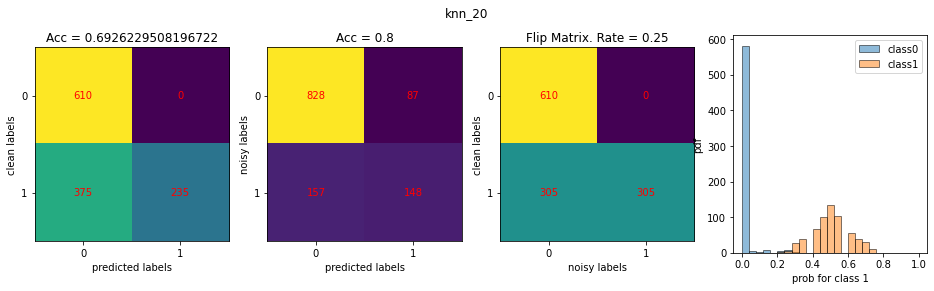

In [8]:
clf2 = KNeighborsClassifier(n_neighbors=20)
clf2.fit(X,y_noisy)
y_pred = clf2.predict(X)
prob = clf2.predict_proba(X)
fig_knn_20 = show_results(y_clean, y_noisy, y_pred, prob, title="knn_20")
fig_knn_20

### MLP classifier

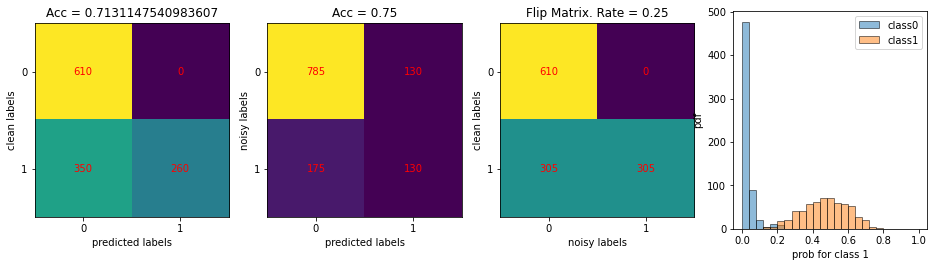

In [18]:
from sklearn.neural_network import MLPClassifier

clf3 = MLPClassifier(hidden_layer_sizes=[], max_iter=20000)
clf3.fit(X,y_noisy)
y_pred = clf3.predict(X)
prob = clf3.predict_proba(X)
fig_mlp = show_results(y_clean, y_noisy, y_pred, prob)
fig_mlp

### Classifier with Noisy Labels

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 10    
------------------------------------
10        Trainable params
0         Non-trainable params
10        Total params
0.000     Total estimated model params size (MB)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

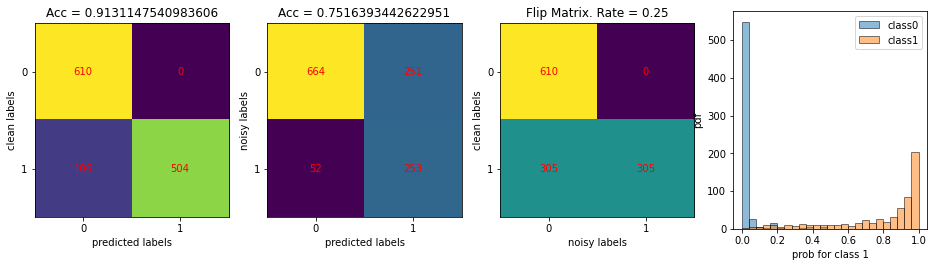

In [19]:
from tissue_purifier.models.classifier_regressor import MlpClassifier
clf4 = MlpClassifier(noisy_labels=True, max_iter=2000, solver='sgd', bootstrap_epoch_start=100)
clf4.fit(X,y_noisy)
y_pred = clf4.predict(X)
prob = clf4.predict_proba(X)
show_results(y_clean, y_noisy, y_pred, prob)